# Portfolio Optimization Using Python

Many indviduals use 401Ks and different retirement tools to help prepare for life after work. Many of these tools depend on managing risk appropiately as to not incure large losses while still taking necessary risk to grow the initial capital. In this series, we will cover the topic of portfolio optimization, a popular technique that financial and investment advisors use to help ensure that their clients are taking appropriate risk to meet their financial objectives.

This tutorial will be broken into a few different sections with each section buildin on top of each other. The first section we will focus on collecting the data necessary for analysis. The data will be pretty simple, just closing price data for a small portfolio of stocks. While in this tutorial, I will focus on using the NASDAQ as my source of data I will be providing different ways on how to get this data in some supplementary code.

After we cover collecting the data, we will then move through the process of preparing the data to calculate a few different metrics that will be crucial for optaining optimial results in our portfolio. A few metrics we will calculate are expected returns, expected volatility, and the Sharpe Ratio. Once we have these metrics defined, we will then move into the process of building a simulation that will randomly generate results that we can use to help determine the optimial results for a wide range of portfolios.

We will take the results of this simulation, plot them using `matplotlib`, and then explore how we can use the `scipy` library to run an optimization algorthim that will return the best weights for our simulation.

In [ ]:
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from pprint import pprint
from sklearn.preprocessing import StandardScaler
from pyopt.client import PriceHistory

# Set some display options for Pandas.
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

In [4]:
# Import the required libraries
import pandas as pd
import pathlib

# Set the path to your dataset file
fec_csv_path = pathlib.Path(r'C:\Users\alert\OneDrive\Desktop\portfolio-optimization\data\dataset_for_PO - FEC.csv')

# Check if the file exists
if fec_csv_path.exists():

    # Load the dataset
    price_data_frame = pd.read_csv(fec_csv_path, parse_dates=['Date'])

    # Set the date column as index
    price_data_frame.set_index('Date', inplace=True)

    # Just to be sure dates are sorted
    price_data_frame.sort_index(inplace=True)

    print("Data loaded successfully. Here's the head:")
    print(price_data_frame.head())

else:
    # If file is not found, raise an error
    raise FileNotFoundError(f"Could not find the file at {fec_csv_path}")

# Now let’s calculate the daily returns
returns = price_data_frame.pct_change().dropna()

# Display the first few rows of returns
print("Daily returns:")
print(returns.head())


Data loaded successfully. Here's the head:
                 MMM       AOS       ABT      ABBV       ACN    ADBE     AMD  \
Date                                                                           
01-02-2024  76.74944  77.81956  111.6860  160.2190  363.0242  627.91  170.48   
01-03-2024  74.72950  82.09344  115.7149  171.0411  372.8899  570.93  202.64   
01-04-2024  91.47808  87.12037  109.3448  172.8098  331.9590  502.09  183.34   
01-05-2024  95.77859  81.28132  104.2011  156.0511  293.4421  469.39  144.27   
01-07-2024  98.56978  78.71889  101.1718  164.3978  297.2642  560.01  157.69   

                 AES       AFL         A  ...      GOOG        MO    AMZN  \
Date                                      ...                               
01-02-2024  16.10343  73.76967  131.8530  ...  142.0373  37.74015  159.28   
01-03-2024  14.51748  78.35831  137.8090  ...  137.4291  36.96219  178.22   
01-04-2024  16.95740  82.99571  144.4848  ...  155.7622  39.96845  180.97   
01-05-2024 

'# Run optimization using Riskfolio\nimport riskfolio as rp\n\n# Create portfolio object\nport = rp.Portfolio(returns=returns)\n\n# Estimate the expected returns and the covariance matrix\nport.assets_stats(method_mu=\'hist\', method_cov=\'hist\')\n\n# Run optimization to maximize Sharpe Ratio\nmodel = \'Classic\'\nrisk_measure = \'MV\'\nobjective = \'Sharpe\'\n\n# Get the optimal weights\nweights = port.optimization(model=model, rm=risk_measure, obj=objective)\n\n# Print the weights\nprint("Optimized Weights:")\nprint(weights)'

The data is pretty close to what we need, but it needs a little bit more massaging before we can jump to the next steps. We can use the `pivot` method to reorganize the data so that we have a single column for each symbol, where each column contains the close price. By having the data like this, we can then calculate the returns for each day.

I think this is a good point to start talking about some of the next steps we are going to do. However, I find it helps to have a high-level overview of the goal, and the tools we will be using to get there. Now at this point, you should recognize that we are using to portfolio of stocks to help generate returns. However, to generate these returns we need to take on **risk**, but ideally we should be comfortable taking on this risk because we are compensated in the form returns that increase our investment.

However, most investors aren't okay with taking on high-levels of risk, so our goal is to find the best ratio of risk vs returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. That naturally leads to an important question, "How do we measure risk?". Well, this can lead you down a rabbit hole because there are many ways to measure risk and some are more appropriate than others depending on the situation at hand. In our case, we will use a very popular metric, the `Sharpe Ratio`. The Sharpe Ratio, is used is a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [31]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Load dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRhjzfMq5pYYnwHaSp5agF7Ul3M2tSn2if4Z4nEPViOj7GBk8gZZQhyTZ7MP857FHgDND4qi7osjrMZ/pub?gid=0&single=true&output=csv"
price_data_frame = pd.read_csv(url)

# Remove date column if present
price_data_frame = price_data_frame.drop(columns=[col for col in price_data_frame.columns if 'date' in col.lower() or 'Date' in col])

# Calculate log returns
log_return = np.log(1 + price_data_frame.pct_change().dropna())

# Set number of assets
number_of_symbols = log_return.shape[1]

# Define objective: negative Sharpe Ratio
def neg_sharpe(weights):
    exp_ret = np.sum(log_return.mean() * weights) * 252
    exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    return -exp_ret / exp_vol

# Constraints and bounds
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(number_of_symbols))
initial_guess = number_of_symbols * [1. / number_of_symbols]

# Optimize
result = minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = result.x

# Compute portfolio metrics
exp_ret = np.sum(log_return.mean() * opt_weights) * 252
exp_vol = np.sqrt(np.dot(opt_weights.T, np.dot(log_return.cov() * 252, opt_weights)))
sharpe_ratio = exp_ret / exp_vol

# Format weights DataFrame for GitHub-style output
weights_df = pd.DataFrame({
    'random_weights': opt_weights,
    'rebalance_weights': opt_weights
}, index=price_data_frame.columns)

# Format metrics
metrics_df = pd.DataFrame({
    'Expected Portfolio Returns': [round(exp_ret, 5)],
    'Expected Portfolio Volatility': [round(exp_vol, 6)],
    'Portfolio Sharpe Ratio': [round(sharpe_ratio, 5)]
})

# Output exactly as requested
print('\n' + '='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

print('\n' + '='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)



PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
       random_weights  rebalance_weights
MMM      3.364508e-02       3.364508e-02
AOS      0.000000e+00       0.000000e+00
ABT      0.000000e+00       0.000000e+00
ABBV     0.000000e+00       0.000000e+00
ACN      0.000000e+00       0.000000e+00
ADBE     1.886265e-13       1.886265e-13
AMD      3.350871e-14       3.350871e-14
AES      1.601722e-13       1.601722e-13
AFL      5.646836e-02       5.646836e-02
A        0.000000e+00       0.000000e+00
APD      0.000000e+00       0.000000e+00
ABNB     7.983590e-15       7.983590e-15
AKAM     3.516186e-14       3.516186e-14
ALB      5.795637e-13       5.795637e-13
ARE      1.564519e-13       1.564519e-13
ALGN     2.427747e-13       2.427747e-13
ALLE     0.000000e+00       0.000000e+00
LNT      0.000000e+00       0.000000e+00
ALL      1.347718e-01       1.347718e-01
GOOGL    6.672567e-02       6.672567e-02
GOOG     1.642612e-13       1.642612e-

# Portfolio Optimization: Monte Carlo

Great, so we now have a way to evaluate how well our portfolio is allocated. It involves, calculating the expected returns, the expected volatility, and then from here we use the Sharpe Ratio to quantify how well our portfolio is allocated based on a risk perspective. The big question here is, "If we know that we want to get a higher sharpe ratio, what is the portfolio allocation we need to achieve this?"

Well, there are two ways to approach this. First, we could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio. Second, we could use mathematical optimization defined by some constrains to arrive at the optimial allocation. In the next section, we will run the "try a bunch of random allocations" method. Now, there is a more formal name for this process, a Monte Carlo Simulation.

**Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forecasting models.**

To do this in python, we will do is run the process we laid out up above and run it a couple thousands of time, and store the results of each run in a data frame. Once we've completed each run, we will find the allocations that produce the highest Sharpe Ratio and the lowest Volatility.

In [33]:
import pandas as pd
import numpy as np

# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRhjzfMq5pYYnwHaSp5agF7Ul3M2tSn2if4Z4nEPViOj7GBk8gZZQhyTZ7MP857FHgDND4qi7osjrMZ/pub?gid=0&single=true&output=csv"
price_data_frame = pd.read_csv(url)

# Drop date column if present
price_data_frame = price_data_frame.drop(columns=[col for col in price_data_frame.columns if 'date' in col.lower() or 'Date' in col])

# Log returns
log_return = np.log(1 + price_data_frame.pct_change().dropna())
number_of_symbols = log_return.shape[1]

# Monte Carlo Simulation
num_of_portfolios = 100000
all_weights = []
ret_arr = []
vol_arr = []
sharpe_arr = []

for _ in range(num_of_portfolios):
    weights = np.random.random(number_of_symbols)
    weights /= np.sum(weights)

    expected_return = np.sum(log_return.mean() * weights) * 252
    expected_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sharpe = expected_return / expected_vol

    all_weights.append(weights)
    ret_arr.append(expected_return)
    vol_arr.append(expected_vol)
    sharpe_arr.append(sharpe)

# Create DataFrame of all simulations
simulations_df = pd.DataFrame({
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr,
    'Portfolio Weights': all_weights
})

# Sort by Sharpe Ratio descending
simulations_df.sort_values(by='Sharpe Ratio', ascending=False, inplace=True)

# Show top 5 portfolios
print('\n' + '='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head(5))
print('-'*80)



SIMULATIONS RESULT:
--------------------------------------------------------------------------------
        Returns  Volatility  Sharpe Ratio  \
88282  0.144592    0.108169      1.336720   
526    0.146184    0.109471      1.335363   
44075  0.143928    0.108516      1.326334   
36754  0.141390    0.107040      1.320910   
94272  0.146172    0.110790      1.319366   

                                       Portfolio Weights  
88282  [0.0029297107408035286, 0.03847562687529057, 0...  
526    [0.04615322918252309, 0.01628591274078053, 0.0...  
44075  [0.053693063813735155, 0.016915882925434726, 0...  
36754  [0.05319549088113488, 0.008584456061201687, 0....  
94272  [0.018206760959266183, 0.03063638196134953, 0....  
--------------------------------------------------------------------------------


# Grab the Important Metrics
Okay now that we ran our simulation let's take a look at some interesting metrics. The first one, we can take a look at is the `max_sharpe_ratio`, this is Sharpe Ratio where the excess return of the portfolio is greatest given the amount of risk we are taking on. In other words, these portfolios are "best" because they provide the largest risk-adjusted returns. The next metric is the `min_volatiltiy`, these are the weights where the overall volatility of the portfolio is at it's lowest. In other words, if you want to take on the least amount of risk, these are the weights you would want to have. 

**Note, where do these numbers end up in our next section where we plot our data?**

In [34]:
# Get Max Sharpe Ratio Portfolio
max_sharpe = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Get Min Volatility Portfolio
min_vol = simulations_df.loc[simulations_df['Volatility'].idxmin()]

# Print Max Sharpe Ratio Portfolio
print('\n' + '='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe)
print('-'*80)

# Print Min Volatility Portfolio
print('\n' + '='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_vol)
print('-'*80)



MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                       0.144592
Volatility                                                    0.108169
Sharpe Ratio                                                   1.33672
Portfolio Weights    [0.0029297107408035286, 0.03847562687529057, 0...
Name: 88282, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                       0.108998
Volatility                                                    0.104752
Sharpe Ratio                                                  1.040531
Portfolio Weights    [0.005399202482369168, 0.028696426574123468, 0...
Name: 34209, dtype: object
--------------------------------------------------------------------------------


# Plotting:

Now producing a bunch of different weights is one thing, but it helps to see the results of our simulation using a graph. We will use `matplotlib` to create a scatter plot that shows the relationship between the overall volatility of our portfolio, and the expected returns from it. Ideally, what we should see is that as we take on more risk, we should be getting higher risk-adjusted returns. The opposite can be said for volaility, the less volatility we take on the lower the expected return we should be getting.

Now as mentioned above, where does the `minimum_volatility` and the `maximum_sharpe_ratio` fall on this grab? Hint, lower volatility means lower risk-adjusted returns.

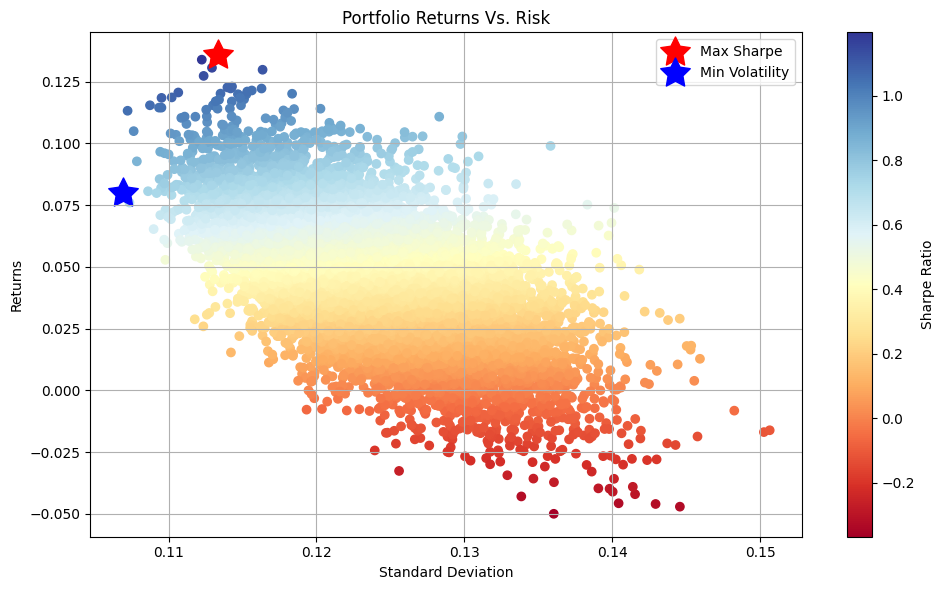

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data (you can also use your local CSV if needed)
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRhjzfMq5pYYnwHaSp5agF7Ul3M2tSn2if4Z4nEPViOj7GBk8gZZQhyTZ7MP857FHgDND4qi7osjrMZ/pub?gid=0&single=true&output=csv"
price_data_frame = pd.read_csv(url)

# Step 2: Clean Data
price_data_frame = price_data_frame.drop(columns=[col for col in price_data_frame.columns if 'date' in col.lower()])
log_return = np.log(1 + price_data_frame.pct_change().dropna())

# Step 3: Initialize Parameters
number_of_symbols = log_return.shape[1]
num_of_portfolios = 10000

all_weights = np.zeros((num_of_portfolios, number_of_symbols))
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)

# Step 4: Run Monte Carlo Simulations
for i in range(num_of_portfolios):
    weights = np.random.random(number_of_symbols)
    weights /= np.sum(weights)

    all_weights[i, :] = weights
    ret_arr[i] = np.sum(log_return.mean() * weights) * 252
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

# Step 5: Create DataFrame
simulations_df = pd.DataFrame({
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr,
    'Portfolio Weights': list(all_weights)
})

# Step 6: Find max Sharpe and min Volatility
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

# Step 7: Plot
plt.figure(figsize=(10, 6))
plt.scatter(simulations_df['Volatility'], simulations_df['Returns'], c=simulations_df['Sharpe Ratio'], cmap='RdYlBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.title('Portfolio Returns Vs. Risk')

# Highlight max Sharpe portfolio
plt.scatter(max_sharpe_ratio['Volatility'], max_sharpe_ratio['Returns'], color='r', marker=(5, 1, 0), s=500, label='Max Sharpe')

# Highlight min Volatility portfolio
plt.scatter(min_volatility['Volatility'], min_volatility['Returns'], color='b', marker=(5, 1, 0), s=500, label='Min Volatility')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Optimization

Alright, now remember that up above I mentioned that we would be exploring multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.

To help run this new optimization method, we will need to define a few more functions that we will use in our method. The first function is the `get_metrics()` function which will return the metrics for a given set of weights provided. In other words, think of it as a "lookup function" where we can return the results of a certain weight. The second function is the `neg_sharpe` function which is used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no `maximize`, so as an objective function you need to pass something that should be minimized.

The third function is `check_sum` function which is used as a constraint. What is will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [36]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Load the data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRhjzfMq5pYYnwHaSp5agF7Ul3M2tSn2if4Z4nEPViOj7GBk8gZZQhyTZ7MP857FHgDND4qi7osjrMZ/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)

# Drop any date column if present
df = df.drop(columns=[col for col in df.columns if 'date' in col.lower()])

# Calculate log returns
log_return = np.log(1 + df.pct_change().dropna())

# Get number of stocks
number_of_symbols = log_return.shape[1]


def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containing return value, volatility value,
        and Sharpe ratio.
    """
    weights = np.array(weights)

    # Annualized return
    ret = np.sum(log_return.mean() * weights) * 252

    # Annualized volatility
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

    # Sharpe Ratio
    sr = ret / vol

    return np.array([ret, vol, sr])


def grab_negative_sharpe(weights: list) -> float:
    """
    ### Overview:
    ----
    This is the function to minimize — negative of Sharpe ratio.

    ### Arguments:
    ----
    weights (list): Portfolio weights.

    ### Returns:
    ----
    (float): Negative Sharpe Ratio (to minimize).
    """
    return -get_metrics(weights)[2]


def grab_volatility(weights: list) -> float:
    """
    ### Overview:
    ----
    This is the function to minimize — volatility.

    ### Arguments:
    ----
    weights (list): Portfolio weights.

    ### Returns:
    ----
    (float): Volatility value.
    """
    return get_metrics(weights)[1]


def check_sum(weights: list) -> float:
    """
    ### Overview:
    ----
    Constraint function to ensure sum of weights = 1.

    ### Arguments:
    ----
    weights (list): Portfolio weights.

    ### Returns:
    ----
    (float): Difference from 1.
    """
    return np.sum(weights) - 1


Okay with our functions now defined, let's run the optimization using the `scipy.optimization` module. This module has a function called `minimize` which we can use to help our optimial values. However, we need to do a few things before we run it. First, we need to define bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation. Second, we need to define the constraint which will be a `fun`(function) that ensures we `equ`(equal) a 100% allocated portfolio. In other words, we use all the "capital" we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case let's make it easy and start with an equally distirbuted portofolio. In this case we have 4 symbols so each symbol will be 25% of the portfolio.

Once we've define this steps we can run the optimization by passing through the arguments defined and defining the `method` as `SLSQP` which is short for `Sequential Least Squares Programming`. Now, the different optimization methods are a whole different topic and is outside the scope of this tutorial. Once we run the `minimize` method we can grab the results.

The first is the results of our minimization operation. Inside the results, you'll see the optimize sharpe ration defined by the `fun` value. We can then take the `optimized_weights` defined by the `optimized_sharpe.x` values, and use them to return the different metrics we have for our portfolio.

In [37]:
# Define the boundaries for each symbol. 
# Remember: We can only invest up to 100% of our capital in any single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraint: total weights must equal 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# Create an initial guess — let's use equal weighting.
# If we have 12 assets, each gets 1/12th of the portfolio.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the optimization to maximize the Sharpe Ratio (by minimizing its negative).
optimized_sharpe = minimize(
    grab_negative_sharpe,     # This is the objective function (negative Sharpe).
    init_guess,               # Start with these weights.
    method='SLSQP',           # Optimization method.
    bounds=bounds,            # Make sure no asset gets more than 100%.
    constraints=constraints   # Ensure total allocation = 100%.
)

# Perform the optimization to minimize the portfolio volatility.
optimized_vol = minimize(
    grab_volatility,          # This is the objective function (volatility).
    init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# ============================
# Print Optimized Sharpe Ratio
# ============================

print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)

sharpe_ret, sharpe_vol, sharpe_sr = get_metrics(optimized_sharpe.x)

print(f"Expected Portfolio Return    : {sharpe_ret:.5f}")
print(f"Expected Portfolio Volatility: {sharpe_vol:.5f}")
print(f"Portfolio Sharpe Ratio       : {sharpe_sr:.5f}")
print(f"Portfolio Weights:")
print(optimized_sharpe.x)

print('-'*80)


# ============================
# Print Minimum Volatility
# ============================

print('')
print('='*80)
print('MINIMUM VOLATILITY PORTFOLIO:')
print('-'*80)

vol_ret, vol_vol, vol_sr = get_metrics(optimized_vol.x)

print(f"Expected Portfolio Return    : {vol_ret:.5f}")
print(f"Expected Portfolio Volatility: {vol_vol:.5f}")
print(f"Portfolio Sharpe Ratio       : {vol_sr:.5f}")
print(f"Portfolio Weights:")
print(optimized_vol.x)

print('-'*80)



OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
Expected Portfolio Return    : 0.33289
Expected Portfolio Volatility: 0.11628
Portfolio Sharpe Ratio       : 2.86271
Portfolio Weights:
[3.36450818e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.88626462e-13 3.35087081e-14 1.60172192e-13
 5.64683635e-02 0.00000000e+00 0.00000000e+00 7.98359046e-15
 3.51618555e-14 5.79563700e-13 1.56451942e-13 2.42774700e-13
 0.00000000e+00 0.00000000e+00 1.34771763e-01 6.67256729e-02
 1.64261217e-13 3.18152077e-01 1.40917807e-01 0.00000000e+00
 1.09965747e-01 0.00000000e+00 1.39353488e-01 4.08274285e-15
 0.00000000e+00 0.00000000e+00]
--------------------------------------------------------------------------------

MINIMUM VOLATILITY PORTFOLIO:
--------------------------------------------------------------------------------
Expected Portfolio Return    : 0.15905
Expected Portfolio Volatility: 0.09574
Portfolio Sharpe Ratio      